In [74]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator, MultipleLocator
from scipy.fft import fft, fftshift, fftfreq, ifft, ifftshift
from tftb.processing.cohen import WignerVilleDistribution as WVD

sys.path.append('../pyVisOS/')
#sys.path.append('../')
import osh5def
import osh5io
import osh5vis
import osh5utils

import Triangle

In [9]:
def getIntersectPoints(m1:np.ndarray,p1:np.ndarray,m2:float,p2:tuple) -> tuple:
    """m1: array containing slopes of incoming lines
    p1 = array containing (x1,y1), points along incoming lines
    m2: slope of line 2
    p2 = (x2,y2): a point along line 2
    returns -> array containing intersection points"""

    b1 = p1[:,1] - m1*p1[:,0]
    b2 = p2[1] - m2*p2[0]

    x_i = (b1-b2)/(m2-m1)
    y_i = m1*x_i + b1

    points = np.array(p1)
    points[:,0] = x_i
    points[:, 1] = y_i

    return points

def angleBetweenTwoSlopes(m1, m2):
    """Returns angle between two lines with slopes m1 and m2, in radians"""
    return np.arctan2((m2-m1),(1+m1*m2)) # perhaps need just arctan

def distance(p1:np.ndarray, p2:np.ndarray) -> np.ndarray:
    """Returns distance between (x1,y1) and (x2,y2)"""
    return np.sqrt((p2[:,0]-p1[:,0])**2 + (p2[:,1]-p1[:,1])**2)

def n(omega, N:float):
    """For a given laser frequency omega [measured in omega_p]
    and relative plasma density N, returns refractive index
    in that plasma

    sqrt(1-N*omega^-2)"""
    return np.sqrt(1-N/(np.square(omega)))

def n_osiris(om, N):
    n_str = str(N).replace('.', '-')
    temp = np.genfromtxt('refractive/n/'+n_str+'.csv',
                             delimiter=',', skip_header=1, names=['omega', 'omega_rel', 'ReN', 'ImN'])

    n_out = np.zeros_like(om)
    delta_omega = temp['omega_rel'][2] - temp['omega_rel'][1]
    for i in range(len(om)):
        a = om[i]
        p1 = a - delta_omega
        p2 = a + delta_omega

        a1 = int(np.argwhere(temp['omega_rel'] > p1)[0])
        a2 = int(np.argwhere(temp['omega_rel'] < p2)[-1])

        #print(a, 'lies between', temp['omega'][a1], 'and', temp['omega'][a2])

        d1 = a - temp['omega_rel'][a1]
        d2 = temp['omega_rel'][a2] - a

        n_out[i] = d2/(d1+d2)*temp['ReN'][a1]+d1/(d1+d2)*temp['ReN'][a2]
    return n_out

def boundary(in_slope:np.ndarray, boundary_slope:float, enter:bool, omega:np.ndarray, N:float):
    """Returns out slope
    enter: True = going from vacuum to plasma
            False = going from plasma to vacuum"""

    normal_slope = -1/boundary_slope
    theta1 = np.abs(angleBetweenTwoSlopes(in_slope, normal_slope))
    if enter:
        theta2 = np.arcsin(n(omega, 0)/n(omega, N)*np.sin(theta1))
    else:
        theta2 = np.arcsin(n(omega, N)/n(omega, 0)*np.sin(theta1))

    greater_case = np.tan(theta2 + np.arctan2(normal_slope,1)) # if in_slope > normal_slope
    smaller_case = np.tan(np.arctan2(normal_slope,1) - theta2) # if in_slope < normal_slope
    
    out_slope = np.where(in_slope > normal_slope, greater_case, smaller_case)
    out_slope = np.where(in_slope == normal_slope, in_slope, out_slope)

    return out_slope

def boundary_osiris(in_slope:np.ndarray, boundary_slope:float, enter:bool, omega:np.ndarray, N:float):
    """Returns out slope
    enter: True = going from vacuum to plasma
            False = going from plasma to vacuum"""

    normal_slope = -1/boundary_slope
    theta1 = np.abs(angleBetweenTwoSlopes(in_slope, normal_slope))
    if enter:
        theta2 = np.arcsin(1/n_osiris(omega, N)*np.sin(theta1))
    else:
        theta2 = np.arcsin(n_osiris(omega, N)/1*np.sin(theta1))

    greater_case = np.tan(theta2 + np.arctan2(normal_slope,1)) # if in_slope > normal_slope
    smaller_case = np.tan(np.arctan2(normal_slope,1) - theta2) # if in_slope < normal_slope
    
    out_slope = np.where(in_slope > normal_slope, greater_case, smaller_case)
    out_slope = np.where(in_slope == normal_slope, in_slope, out_slope)

    return out_slope

def drawSegment(ax, p1, p2, **kwargpassthrough):
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], **kwargpassthrough)

def raytrace(N, omega:np.ndarray, left_sides, right_sides, tips):
    intersections = np.ndarray(shape=(len(left_sides)+len(right_sides)+2, len(omega), 2))
    lengths = np.ndarray(shape=(len(left_sides)+len(right_sides)+1, len(omega)))

    m = np.zeros_like(omega) # all frequencies start fully horizontal
    points = np.full((len(omega),2), (0.,0.))

    num = 0
    intersections[num] = points # first row is starting points for all omega
    # for now this they are all (0,0), but if i wanted to start with some frequencies delayed (chirp)
    # this is where that could be set
    num += 1

    for i in range(len(tips)):
        intersections[num] = getIntersectPoints(m, intersections[num-1], left_sides[i], tips[i])
        m = boundary(m, left_sides[i], True, omega, N)
        lengths[num-1] = distance(intersections[num-1], intersections[num])
        num += 1

        intersections[num] = getIntersectPoints(m, intersections[num-1], right_sides[i], tips[i])
        m = boundary(m, right_sides[i], False, omega, N)
        lengths[num-1] = distance(intersections[num-1], intersections[num])
        num += 1

    intersections[num] = getIntersectPoints(m, intersections[num-1], 1, intersections[num-1, 0] + [1000,0])
    lengths[num-1] = distance(intersections[num-1], intersections[num])
    
    return intersections, lengths

def raytrace_osiris(N, omega:np.ndarray, left_sides, right_sides, tips):
    intersections = np.ndarray(shape=(len(left_sides)+len(right_sides)+2, len(omega), 2))
    lengths = np.ndarray(shape=(len(left_sides)+len(right_sides)+1, len(omega)))

    m = np.zeros_like(omega) # all frequencies start fully horizontal
    points = np.full((len(omega),2), (0.,0.))

    num = 0
    intersections[num] = points # first row is starting points for all omega
    # for now this they are all (0,0), but if i wanted to start with some frequencies delayed (chirp)
    # this is where that could be set
    num += 1

    for i in range(len(tips)):
        intersections[num] = getIntersectPoints(m, intersections[num-1], left_sides[i], tips[i])
        m = boundary_osiris(m, left_sides[i], True, omega, N)
        lengths[num-1] = distance(intersections[num-1], intersections[num])
        num += 1

        intersections[num] = getIntersectPoints(m, intersections[num-1], right_sides[i], tips[i])
        m = boundary_osiris(m, right_sides[i], False, omega, N)
        lengths[num-1] = distance(intersections[num-1], intersections[num])
        num += 1

    intersections[num] = getIntersectPoints(m, intersections[num-1], 1, intersections[num-1, 0] + [1000,0])
    lengths[num-1] = distance(intersections[num-1], intersections[num])
    
    return intersections, lengths

def plotPrisms(ax, N, tip1, tip2, mirror, theta):
    theta = np.deg2rad(theta)    # convert to radians
    tips = [tip1, tip2]
    alpha = np.pi/2. + theta - np.arcsin(n(1, N)*np.sin(theta))

    tips.append((2*mirror - tips[1][0], tips[1][1]))
    tips.append((2*mirror - tips[0][0], tips[0][1]))
    left_sides = [np.tan(alpha - theta), np.tan(alpha + theta), np.tan(-alpha + theta), np.tan(-alpha - theta)]
    right_sides = [np.tan(alpha + theta), np.tan(alpha - theta), np.tan(-alpha - theta), np.tan(-alpha + theta)]
    mid_slopes = [np.tan(alpha), np.tan(alpha), np.tan(-alpha), np.tan(-alpha)]
    for i in range(len(tips)):
        X = np.linspace(0, tips[i][0], 2)
        ax.plot(X, left_sides[i]*(X-tips[i][0])+tips[i][1], c='black', linestyle='--')
        X = np.linspace(0, mirror*2, 2)
        ax.plot(X, mid_slopes[i]*(X-tips[i][0])+tips[i][1], c='blue', linestyle=':', alpha=0.5)
        X = np.linspace(tips[i][0], mirror*2, 2)
        ax.plot(X, right_sides[i]*(X-tips[i][0])+tips[i][1], c='black', linestyle='--')

        
    return left_sides, right_sides, tips

def phaseAccumulation(N, om, lengths):
    # lengths[segments, omega]
    psi = np.zeros_like(om)
    vacuumLength = np.sum(lengths[::2], axis=0)
    plasmaLength = np.sum(lengths[1::2], axis=0)
    psi = om*(n(om, 0)*vacuumLength + n(om,N)*plasmaLength)
    return psi

def OPL(N, om, lengths):
    opl = np.zeros_like(om) # [segments, omega]
    vacuumLength = np.sum(lengths[::2], axis=0)
    plasmaLength = np.sum(lengths[1::2], axis=0)
    opl = n(om, 0) * vacuumLength + n(om, N) * plasmaLength
    return opl
    
def phaseAccumulation_osiris(N, om, lengths):
    # lengths[segments, omega]
    psi = np.zeros_like(om)
    vacuumLength = np.sum(lengths[::2], axis=0)
    plasmaLength = np.sum(lengths[1::2], axis=0)
    psi = om*(1*vacuumLength + n_osiris(om,N)*plasmaLength)
    return psi

def OPL_osiris(N, om, lengths):
    opl = np.zeros_like(om) # [segments, omega]
    vacuumLength = np.sum(lengths[::2], axis=0)
    plasmaLength = np.sum(lengths[1::2], axis=0)
    opl = 1 * vacuumLength + n_osiris(om, N) * plasmaLength
    return opl

In [3]:
c = 299792458*1e6*1e-15 # um / fs
om_0 = 2*np.pi*c/0.8 # 1/fs
L = 300 # length of pulse in c/omega_p units
print(L, '[c/ω0] =', L * c/om_0, '[μm] =', L / om_0, '[fs]')


300 [c/ω0] = 38.197186342054884 [μm] = 127.41209901302746 [fs]


54.73561031724534


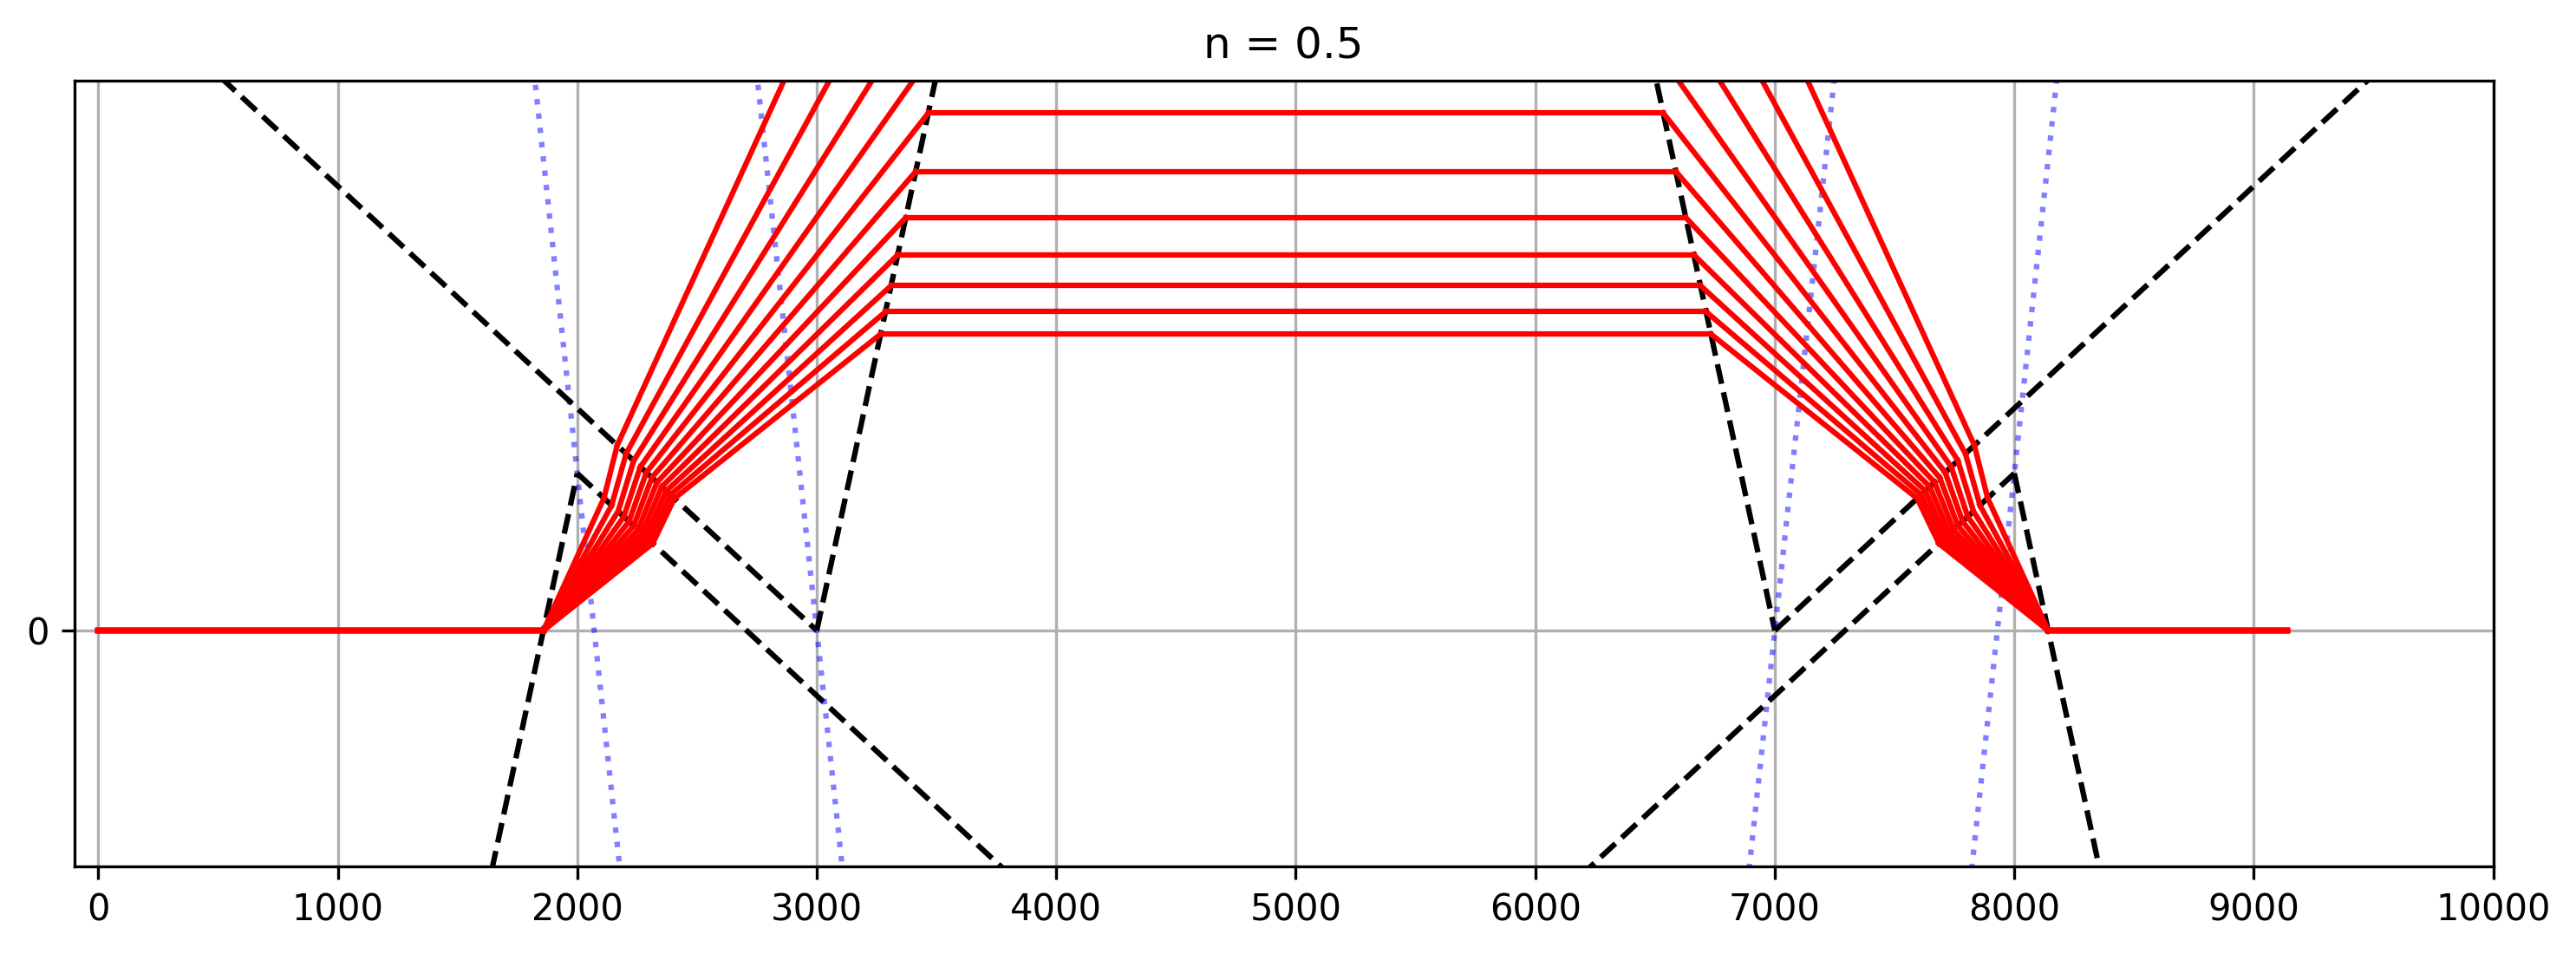

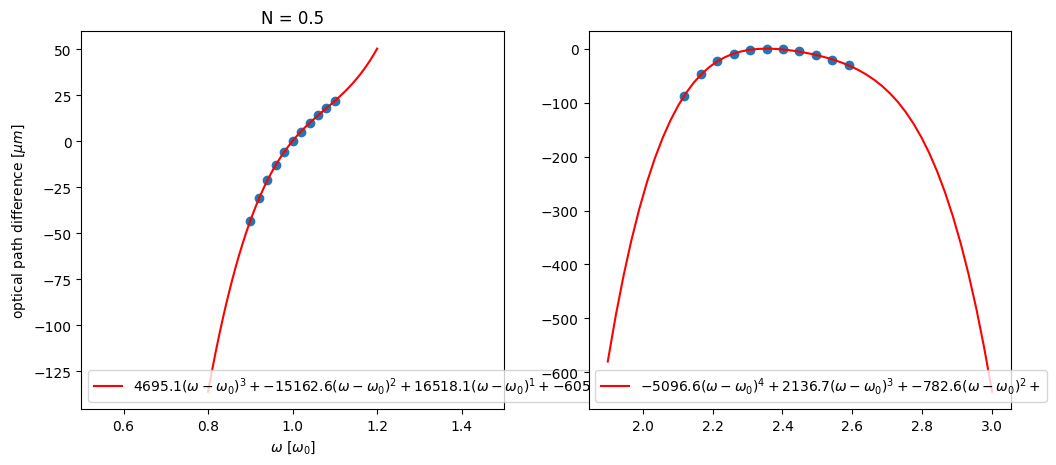

In [85]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(12,4))

N = 0.5
mirror = 5000
brewster = np.arctan2(n(1,N), 1)
theta = np.arcsin(np.sin(brewster) / n(1,N)) * 180/np.pi
tip1 = (1500,200)
tip2 = (3000,0)
#theta = 30
print(theta)

c = 299792458*1e6*1e-15 # um / fs
om_0 = 2*np.pi*c/0.8 # 1/fs
#0.4, 30, (400,300), (1700, 0), 2100, 800))
left_sides, right_sides, tips = plotPrisms(ax, N, tip1, tip2, mirror, theta)

#om = w_2[7::8]
#print(om[0], om[-1])
ax.set(ylim=[-300,700], xlim=[-100,mirror*2], title='n = %.1f' % N)
if True:
    ax.grid()
    ax.xaxis.set_major_locator(MultipleLocator(1000))
    ax.yaxis.set_major_locator(MultipleLocator(1000))

    #om = np.array([0.9, 1., 1.1])
    om = np.array([ 0.9, 0.92, 0.94, 0.96, 0.98, 1., 1.02, 1.04, 1.06, 1.08, 1.1])
    
    #colors = [ 'darkred', 'red', 'orangered', 'orange', 'yellow', 'greenyellow', 'green', 'lightseagreen', 'deepskyblue', 'blue', 'aquamarine']


    intersections, lengths = raytrace(N, om, left_sides, right_sides, tips)
    intersections_osiris, lengths_osiris = raytrace_osiris(N, om, left_sides, right_sides, tips)

    psi = phaseAccumulation(N, om, lengths)
    psi -= psi[np.argwhere(om >= 1.)[0]]

    psi_osiris = phaseAccumulation_osiris(N, om, lengths_osiris)
    psi_osiris -= psi_osiris[np.argwhere(om >= 1.)[0]]

    opl = OPL(N, om, lengths)
    opl -= opl[np.argwhere(om >= 1.)[0]]
    opl *= 0.8 / 2 / np.pi

    for freq in range(len(om)):
        for boundaryline in range(1, len(intersections)):
            drawSegment(ax, intersections[boundaryline-1, freq], intersections[boundaryline, freq], c='red')

            #drawSegment(ax, intersections_osiris[boundaryline-1, freq], intersections_osiris[boundaryline, freq], alpha=1., linestyle='--', c='b')


    # plot optical path difference
    fig, ax = plt.subplots(1, 2, dpi=100, figsize=(12,5))
    ax[0].scatter(om, opl)
    ax[0].set(xlim=[0.5, 1.5], xlabel=r'$\omega$ [$\omega_0$]', ylabel=r'optical path difference [$\mu m$]', title='N = '+str(N))

    coeff = np.polyfit(om, opl, 3)
    x = np.linspace(0.8, 1.2)
    y = np.zeros_like(x)
    s = ''
    for i in range(len(coeff)):
        y += coeff[i]*x**(len(coeff)-1-i)
        if len(coeff)-1-i != 0:
            s += r'$%.1f (\omega-\omega_0)^%d + $' % (coeff[i], len(coeff)-1-i)
        else:
            s += r'$%.1f$' % coeff[i]
    ax[0].plot(x, y, label=s, c='r')#, label=r'n=0.4: $%.1f \omega^3 + %.1f \omega^2 + %.1f \omega + %.1f$' % (p_4[0], p_4[1], p_4[2], p_4[3]))
    ax[0].legend()

    # plot phase delay

    om_2 = om*om_0
    
    # plot with n
    if True:
        coeff = np.polyfit(om_2-om_0, psi, 4)
        x = np.linspace(1.9, 3)
        y = np.zeros_like(x)
        s = ''
        for i in range(len(coeff)):
            y += coeff[i]*(x-om_0)**(len(coeff)-1-i)
            if len(coeff)-1-i != 0:
                s += r'$%.1f (\omega-\omega_0)^%d + $' % (coeff[i], len(coeff)-1-i)
            else:
                s += r'$%.1f$' % coeff[i]
        #ax[0].plot(x, y, label=s, c='r')#, label=r'n=0.4: $%.1f \omega^3 + %.1f \omega^2 + %.1f \omega + %.1f$' % (p_4[0], p_4[1], p_4[2], p_4[3]))
        #ax[0].legend()

        psi_shifted = psi - coeff[-2]*(om_2-om_0) - coeff[-1]
        ax[1].scatter(om_2, psi_shifted)
        z = np.zeros_like(x)
        s = ''
        for i in range(len(coeff)-2):
            z += coeff[i]*(x-om_0)**(len(coeff)-1-i)
            s += r'$%.1f (\omega-\omega_0)^%d + $' % (coeff[i], len(coeff)-1-i)
        ax[1].plot(x, z, label=s, c='r')#, label=r'n=0.4: $%.1f \omega^3 + %.1f \omega^2 + %.1f \omega + %.1f$' % (p_4[0], p_4[1], p_4[2], p_4[3]))

    # plot with n_osiris
    if False:
        coeff = np.polyfit(om_2-om_0, psi_osiris, 3)
        x = np.linspace(1.9, 3)
        y = np.zeros_like(x)
        s = ''
        for i in range(len(coeff)):
            y += coeff[i]*(x-om_0)**(len(coeff)-1-i)
            if len(coeff)-1-i != 0:
                s += r'$%.1f (\omega-\omega_0)^%d + $' % (coeff[i], len(coeff)-1-i)
            else:
                s += r'$%.1f$' % coeff[i]
        #ax[0].plot(x, y, label=s, c='r')#, label=r'n=0.4: $%.1f \omega^3 + %.1f \omega^2 + %.1f \omega + %.1f$' % (p_4[0], p_4[1], p_4[2], p_4[3]))
        #ax[0].legend()

        psi_shifted = psi_osiris - coeff[-2]*(om_2-om_0) - coeff[-1]
        ax[1].scatter(om_2, psi_shifted)
        z = np.zeros_like(x)
        s = ''
        for i in range(len(coeff)-2):
            z += coeff[i]*(x-om_0)**(len(coeff)-1-i)
            s += r'$%.1f (\omega-\omega_0)^%d + $' % (coeff[i], len(coeff)-1-i)
        ax[1].plot(x, z, label='OSIRIS: '+s, c='g')#, label=r'n=0.4: $%.1f \omega^3 + %.1f \omega^2 + %.1f \omega + %.1f$' % (p_4[0], p_4[1], p_4[2], p_4[3]))

    ax[1].legend()

In [86]:
print(Triangle.triangle(N, tip1, tip2, mirror, 700))

"(if((1.41*x1 - 938 - x2 > 0) && (-0.28*x1 + 1920 - x2 > 0),
	 if(-2.83*x1 + 5857 - x2 > 0,
	 0.5 * tanh(0.005*(1.41*x1 - 2628 - x2)) + 0.5,
	 0.5 * tanh(0.005*(-0.28*x1 + 766 - x2)) + 0.5),
	 0)

 + if((-0.28*x1 + 592 - x2 < 0) && (1.41*x1 - 4725 - x2 < 0),
	 if(-2.83*x1 + 8485 - x2 > 0,
	 0.5 * tanh(0.005*(-(-0.28*x1 + 849 - x2))) + 0.5,
	 0.5 * tanh(0.005*(-(1.41*x1 - 4243 - x2))) + 0.5),
	 0)

 + if((-1.41*x1 + 9417 - x2 < 0) && (0.28*x1 - 2236 - x2 < 0),
	 if(2.83*x1 - 19799 - x2 < 0,
	 0.5 * tanh(0.005*(-(-1.41*x1 + 9899 - x2))) + 0.5,
	 0.5 * tanh(0.005*(-(0.28*x1 - 1980 - x2))) + 0.5),
	 0)

 + if((0.28*x1 - 1806.2 - x2 > 0) && (-1.41*x1 + 11996.6 - x2 > 0),
	 if(2.83*x1 - 22427 - x2 < 0,
	 0.5 * tanh(0.005*(0.28*x1 - 2063 - x2)) + 0.5,
	 0.5 * tanh(0.005*(-1.41*x1 + 11514 - x2)) + 0.5),
	 0))

*step(x2 + 500)*step(-x2 + 700)",


In [14]:
data = osh5io.read_h5('e2-000000.h5', './2d plasma short/MS/FLD/e2/')
print(np.argwhere(np.abs(data.axes[0].ax) < 0.5)[0][0])
arr = data.view(np.ndarray)[np.argwhere(np.abs(data.axes[0].ax) < 0.5)[0][0]]

""" data2 = osh5io.read_h5('e2-000083.h5', './2d 4 triangle//MS/FLD/e2/')
print(np.argwhere(np.abs(data2.axes[0].ax) < 0.5)[0][0])
arr2 = data2.view(np.ndarray)[np.argwhere(np.abs(data2.axes[0].ax) < 0.5)[0][0]] """


456


" data2 = osh5io.read_h5('e2-000083.h5', './2d 4 triangle//MS/FLD/e2/')\nprint(np.argwhere(np.abs(data2.axes[0].ax) < 0.5)[0][0])\narr2 = data2.view(np.ndarray)[np.argwhere(np.abs(data2.axes[0].ax) < 0.5)[0][0]] "

Δt = 0.4247069967100856
tau_1 = 30.0


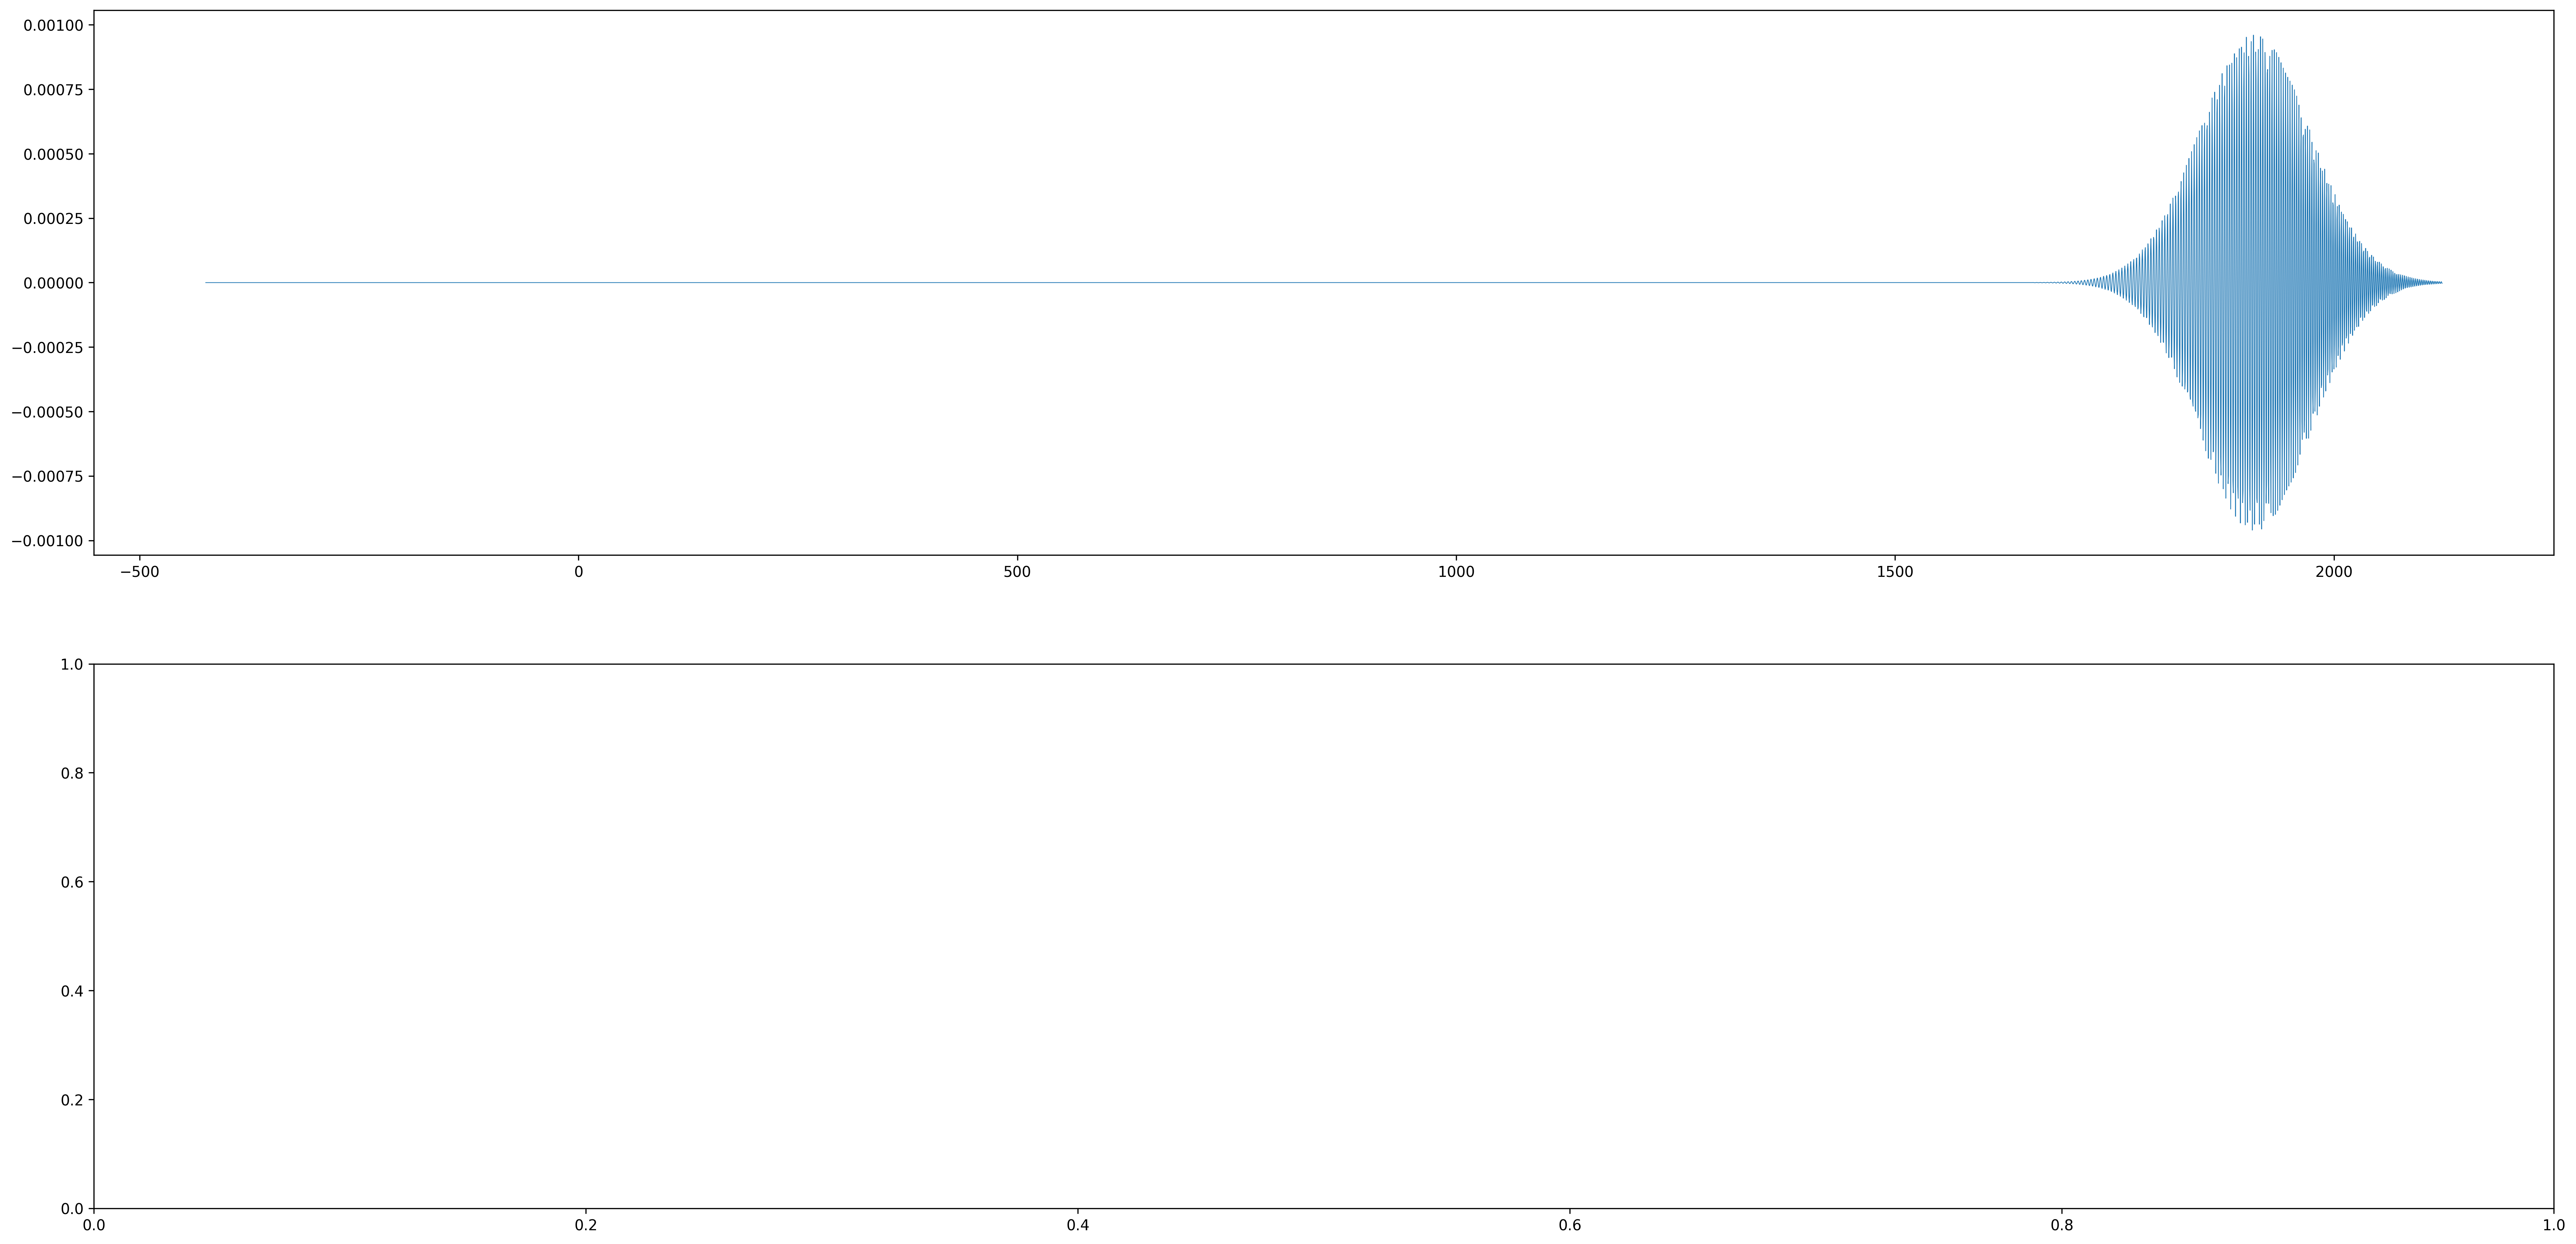

In [21]:
N = 2**14
c = 299792458*1e6*1e-15 # um / fs, speed of light
lamda = .8 # um
om_0 = 2*np.pi*c/lamda # 1/fs, ~2.36

E_0 = 2
tau_0 = 30 # fs
c_0 = 0 # chirp

#t = np.linspace(-tau_0*16,tau_0*16, N)
t = data.axes[1].ax / om_0
#E_in = np.exp(-0.5*((t/tau_0)**2)) * np.real(E_0 * np.exp(-0.5*((t/tau_0)**2)*(1j*c_0)) * np.exp(-1j*om_0*t))
E_in = arr
E_in = E_in[::-1]

delta_t = t[2]-t[1]
delta_omega = 2*np.pi/(N*delta_t)

print('Δt =', delta_t)

tau_1 = tau_0 / np.sqrt(1 + c_0**2)
print('tau_1 =', tau_1)
""" E_1 = 2
c_1 = 0
E_out = np.real(E_1 * np.exp(-0.5*((t/tau_1)**2)*(1+1j*c_1)) * np.exp(-1j*(om_0)*t)) """

""" t2 = data2.axes[1].ax
E_out = arr2
E_out = E_out[::-1] """

""" t2 = data2.axes[1].ax
E_out = arr2
E_out = E_out[::-1] """

fig, ax = plt.subplots(2, 1, dpi=300, figsize=(30,15))
ax[0].plot(t, E_in, linewidth=0.5)
#ax[0].axvline(-3*tau_0, c='r')
#ax[0].axvline(3*tau_0, c='r')
#ax[1].plot(t2, E_out, linewidth=0.5)

In [16]:
def func(E_in, om_0, delta_t, a, b, c, d):
    phi = lambda w, a, b, c : a*(w) + b*(w**2) + c*(w**3) + d*(w**4)
    F_in = fft(E_in) * delta_t
    w = fftfreq(E_in.size, d=delta_t) * 2*np.pi
    pos_w = w[w >= 0] # positive half
    neg_w = w[w < 0]

    zeropoint = np.exp(-1j*phi(pos_w[0]-om_0, a, b, c))
    pos_fltr = np.exp(-1j*phi(pos_w[1:]-om_0, a, b, c))
    neg_fltr = np.conj(pos_fltr)
    lastpoint = np.exp(-1j*phi(neg_w[0]-om_0, a, b, c))

    fltr = np.concatenate(([zeropoint], pos_fltr, [lastpoint], neg_fltr[::-1]))

    F_out = F_in * fltr

    E_out = ifft((F_out) / delta_t)


    threshold = 1e-4
    w_peaks = w[np.argwhere(np.abs(F_out)**2 > threshold)]

    F_peaks = F_out[np.argwhere(np.abs(F_out)**2 > threshold)]
    F_peaks = F_peaks[w_peaks >= 0]
    w_peaks = w_peaks[w_peaks >= 0]

    return E_out, w_peaks

In [294]:
print(coeff[-4])

174.5557061000851


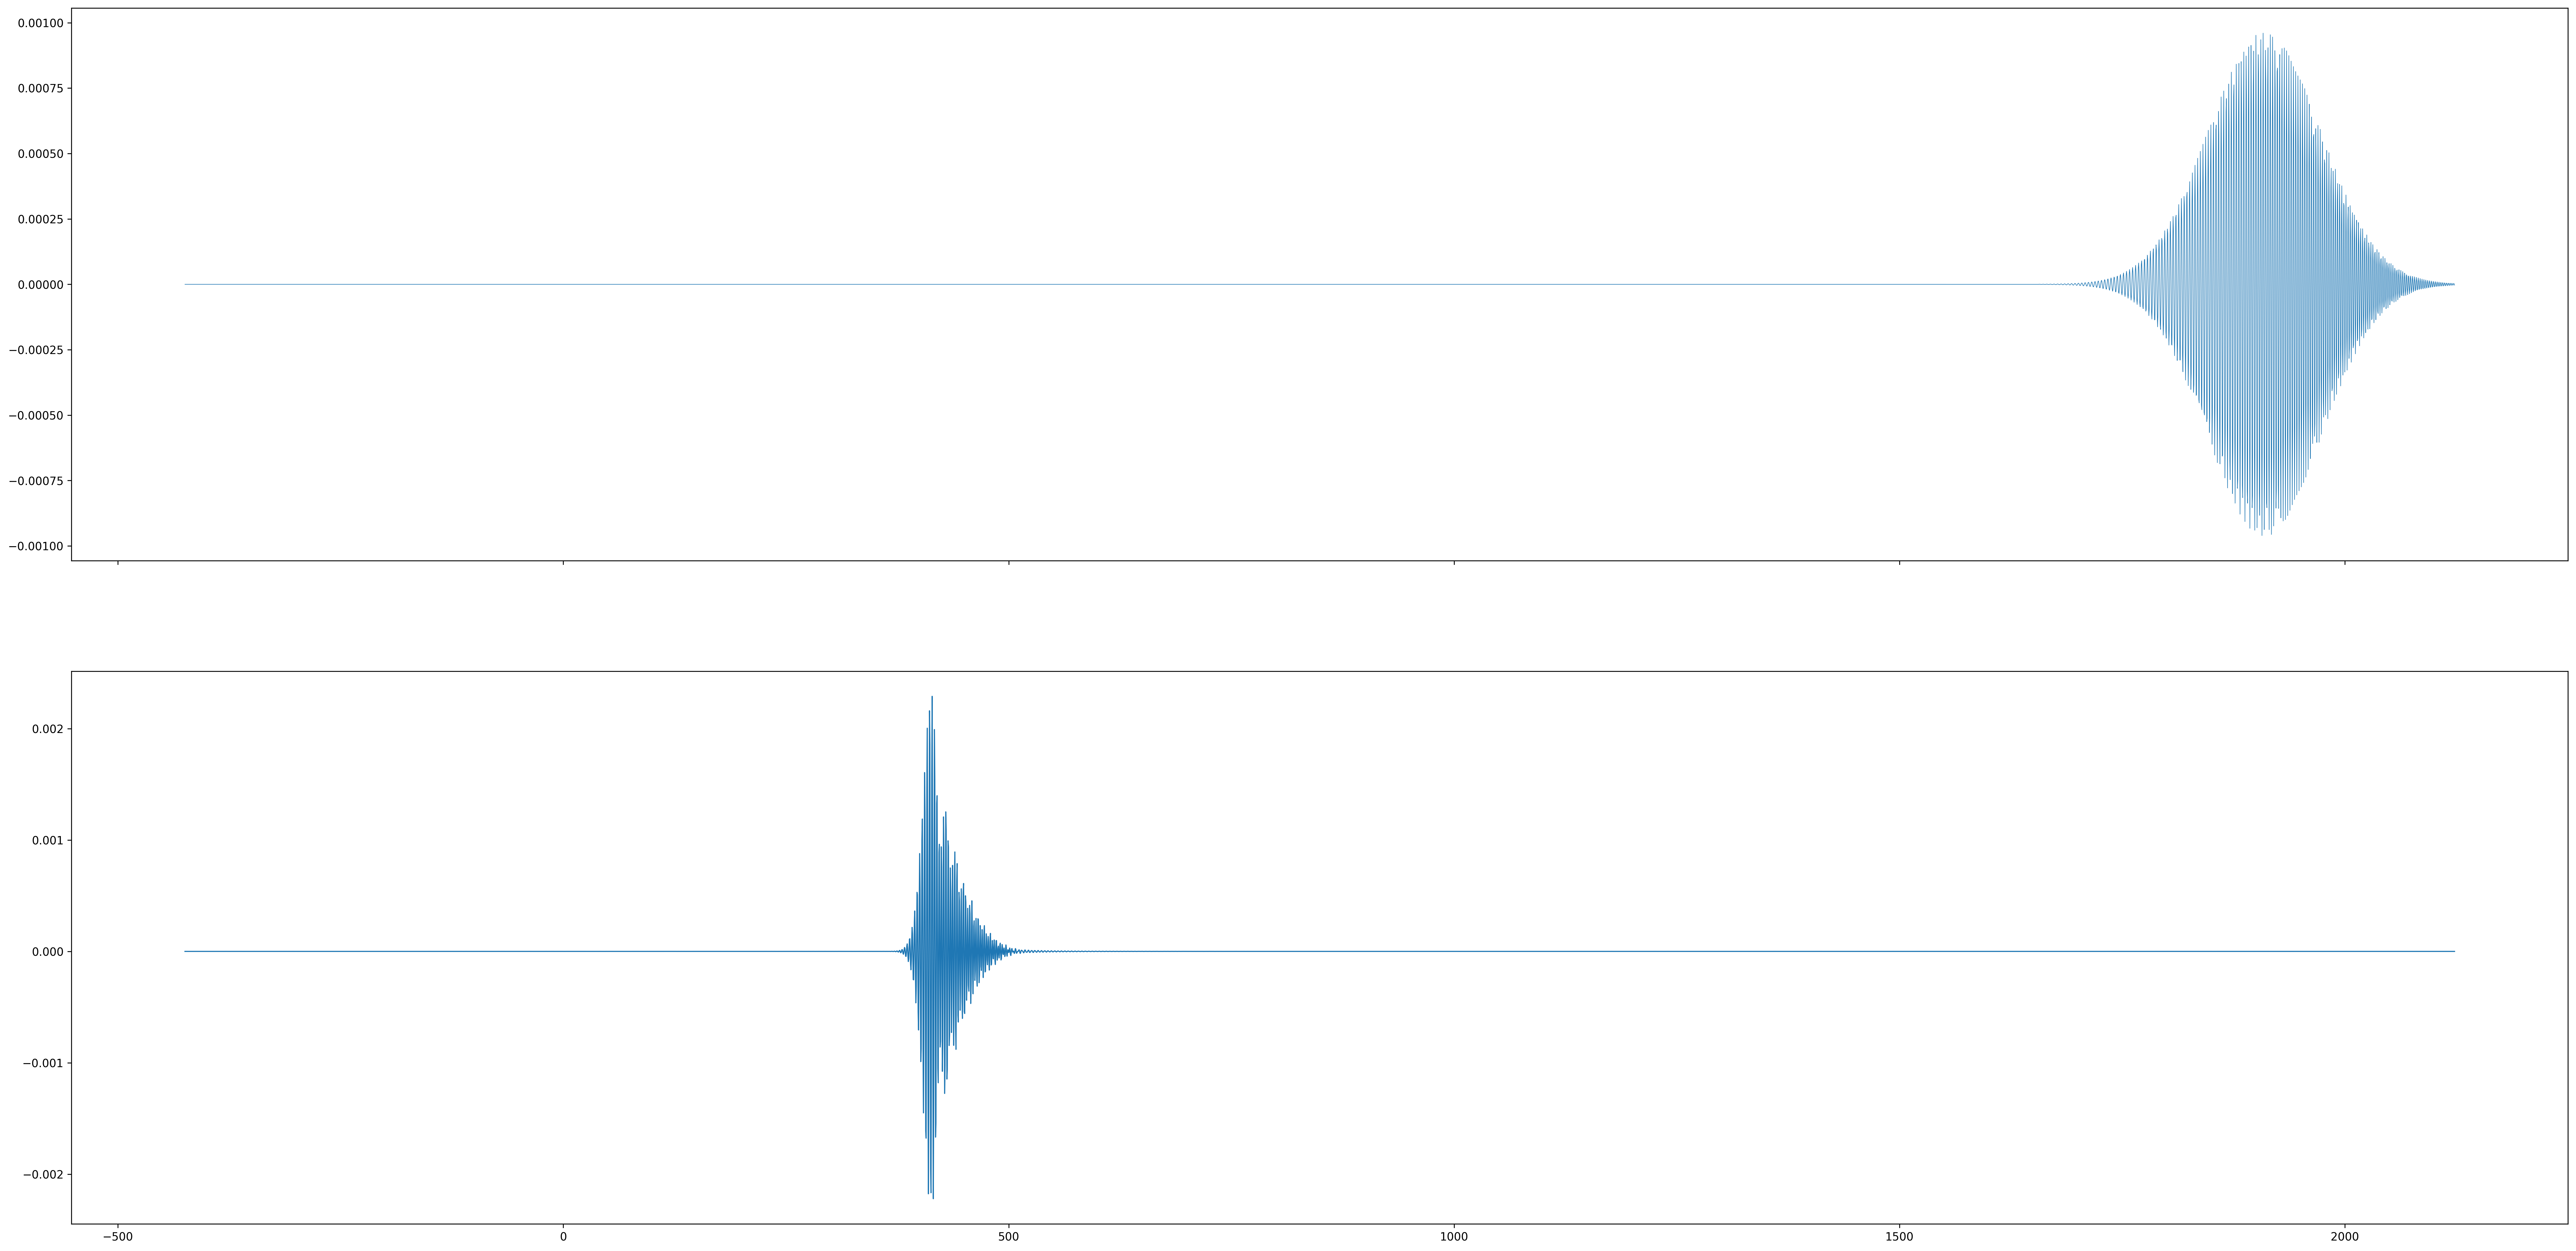

In [70]:
E_out_2, w_2 = func(E_in, om_0, delta_t, 0, 0, 0, 25.**4)
E_out_3, _ = func(E_in, om_0, delta_t, 1050, coeff[-3], coeff[-4], coeff[-5])
fig, ax = plt.subplots(2, 1, dpi=300, figsize=(40,20), sharex=True)
#ax[0].plot(t, E_out, linewidth=0.5)
#ax[1].plot(t, np.real(E_out_2), linewidth=0.5)
ax[0].plot(t, E_in, linewidth=0.5)
ax[1].plot(t, np.real(E_out_3), linewidth=1)
#ax[0].plot(t, E_out, linewidth=1)

#ax[1].set(xlim=[400,600]);

WXYZ


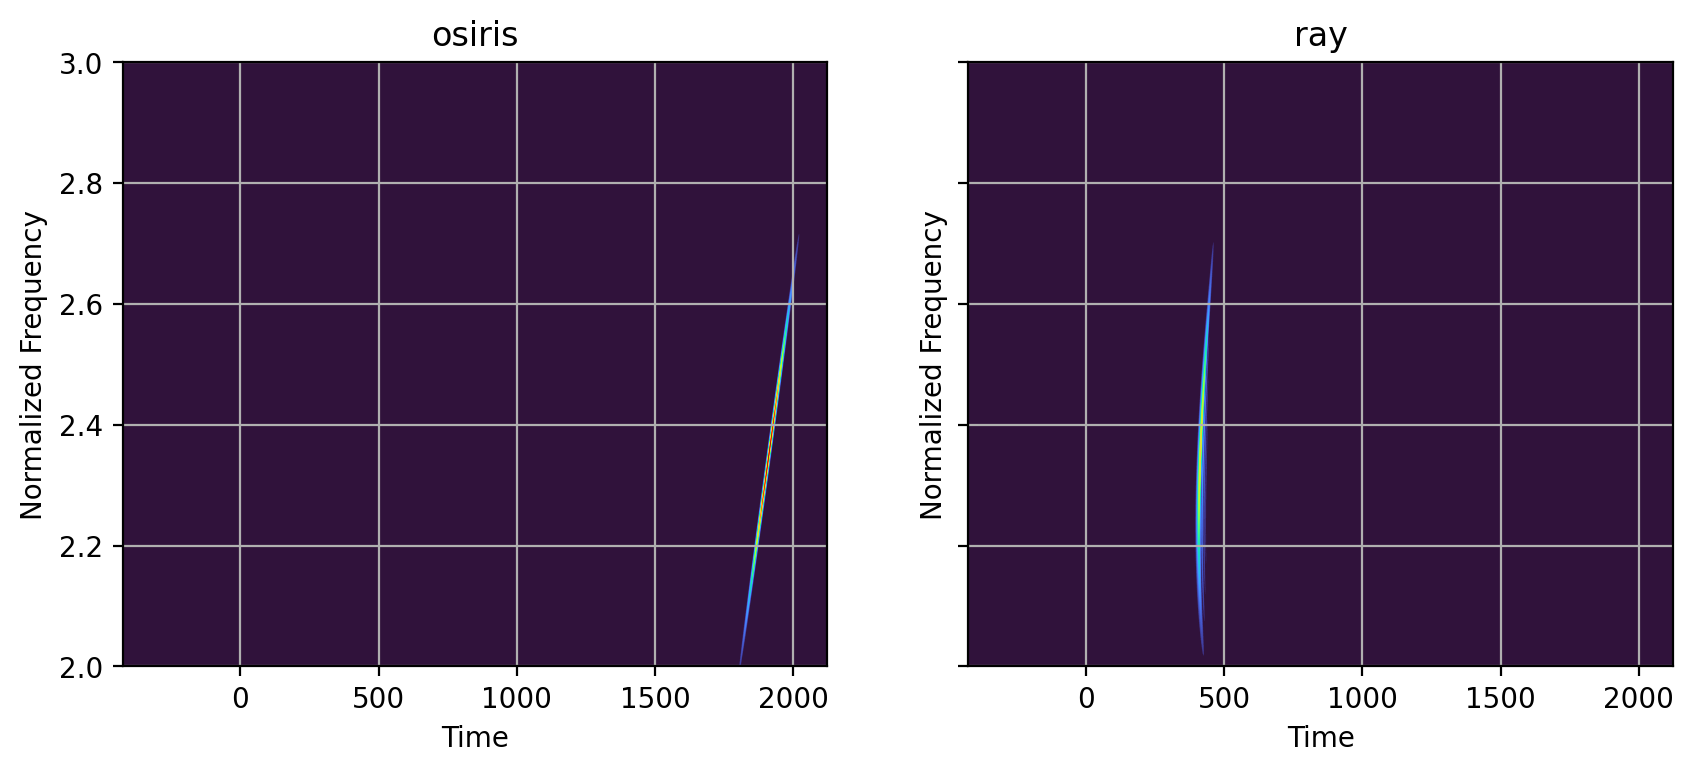

In [71]:
fig, ax = plt.subplots(1,2, dpi=200, figsize=(10,4), sharey=True)

wig1 = WVD(E_in, timestamps=t)
wig1.run(True)
print('W', end='')
wig1.plot(ax=ax[0], show=False, cmap='turbo')
print('X', end='')
ax[0].set(title='osiris')

wig2 = WVD(E_out_3, timestamps=t)
wig2.run(True)
print('Y', end='')
wig2.plot(ax=ax[1], show=False, cmap='turbo')
print('Z')
ax[1].set(ylim=[2,3], title='ray');
